# The Import

In [1]:
import numpy as np
import pandas as pd
import os
import email
import email.policy
import re
from bs4 import BeautifulSoup
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import roc_auc_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, recall_score, accuracy_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from scipy.sparse import coo_matrix, hstack
from sklearn.metrics import log_loss
from sklearn.metrics import f1_score
###########################################################################################

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
import nltk
nltk.download('wordnet')
import pickle
from sklearn.metrics import classification_report
from tqdm import tqdm
import os

from jupyterthemes import jtplot
jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)
#!jt -t monokai

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\lette\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# First task is to create a Dataset from the given files

In [2]:
# Locating our files
root_location = r"C:\Users\lette\Documents\Learning Materials\Udemy - Complete 2020 Data Science & Machine Learning Bootcamp\6. Pre-Process Text Data for a Naive Bayes Classifier to Filter Spam Emails Part 1\Kaggle_data"
root_ham = r"C:\Users\lette\Documents\Learning Materials\Udemy - Complete 2020 Data Science & Machine Learning Bootcamp\6. Pre-Process Text Data for a Naive Bayes Classifier to Filter Spam Emails Part 1\Kaggle_data\ham"
root_spam = r"C:\Users\lette\Documents\Learning Materials\Udemy - Complete 2020 Data Science & Machine Learning Bootcamp\6. Pre-Process Text Data for a Naive Bayes Classifier to Filter Spam Emails Part 1\Kaggle_data\spam"
root_hamspam = r"C:\Users\lette\Documents\Learning Materials\Udemy - Complete 2020 Data Science & Machine Learning Bootcamp\6. Pre-Process Text Data for a Naive Bayes Classifier to Filter Spam Emails Part 1\Kaggle_data\hamnspam"

os.listdir(root_location)

['ham', 'hamnspam', 'spam']

In [3]:
# Listing out the files that are present in each folders
ham_filenames = [name for name in sorted(os.listdir(root_ham)) if len(name) > 10]
spam_filenames = [name for name in sorted(os.listdir(root_spam)) if len(name) > 10]

In [4]:
print('Total ham emails: ',len(ham_filenames))
print('Total spam emails: ',len(spam_filenames))
print('Spam percentage: ',100*(len(spam_filenames)/(len(ham_filenames)+len(spam_filenames)))," %")

Total ham emails:  2551
Total spam emails:  501
Spam percentage:  16.41546526867628  %


In [5]:
# How each of the files look like
with open(os.path.join(root_ham, ham_filenames[20]), "rb") as file:
    ham_email =  email.parser.BytesParser(policy=email.policy.default).parse(file)

print('Header field names: \n',ham_email.keys())
print('\n', '-'*120, '\n')
print('Message field values: \n',ham_email.values())
print('\n', '-'*120, '\n')
print('Message content:',ham_email.get_content()[:200])

Header field names: 
 ['Return-Path', 'Delivered-To', 'Received', 'Received', 'Received', 'X-Egroups-Return', 'Received', 'X-Sender', 'X-Apparently-To', 'Received', 'Received', 'Received', 'Received', 'Received', 'To', 'Message-Id', 'In-Reply-To', 'User-Agent', 'X-Mailer', 'From', 'X-Originating-Ip', 'X-Yahoo-Profile', 'MIME-Version', 'Mailing-List', 'Delivered-To', 'Precedence', 'List-Unsubscribe', 'Date', 'Subject', 'Reply-To', 'Content-Type', 'Content-Transfer-Encoding']

 ------------------------------------------------------------------------------------------------------------------------ 

Message field values: 
 ['<robert.chambers@baesystems.com>', 'zzzz@localhost.netnoteinc.com', 'from localhost (localhost [127.0.0.1])\tby phobos.labs.netnoteinc.com (Postfix) with ESMTP id F2AD843F99\tfor <zzzz@localhost>; Thu, 22 Aug 2002 12:19:25 -0400 (EDT)', 'from phobos [127.0.0.1]\tby localhost with IMAP (fetchmail-5.9.0)\tfor zzzz@localhost (single-drop); Thu, 22 Aug 2002 17:19:26 +0100

In [6]:
# This will process a spam email file located at a specified directory and returns it as an email object
def upload_ham_spam(files,directory):
    with open(os.path.join(directory, files), "rb") as file:
        return email.parser.BytesParser(policy=email.policy.default).parse(file)

ham_emails = [upload_ham_spam(files=name,directory=root_ham) for name in ham_filenames]
spam_emails = [upload_ham_spam(files=name,directory=root_spam) for name in spam_filenames]

# Building the dataset to train the model

In [10]:
ham_emails[2500].get_all("To")

['yyyy@example.com']

In [87]:
ham_dataset = []
spam_dataset = []
ham_subject = []
spam_subject = []
ham_to = []
spam_to = []
ham_from = []
spam_from = []
#Ham processing
for i in range(len(ham_emails)):
    ham_dataset.append(ham_emails[i].get_body().get_payload())
    ham_subject.append(ham_emails[i].get_all("Subject"))
    ham_to.append(ham_emails[i].get_all("To"))
    ham_from.append(ham_emails[i].get_all("From"))
ham_dataset = pd.DataFrame(ham_dataset,columns=['Email_Content'])
ham_dataset['Email_Subject'] = ham_subject
ham_dataset['Email_To'] = ham_to
ham_dataset['Email_From'] = ham_from
ham_dataset['Label'] = 0

#Spam processing
for i in range(len(spam_emails)):
    spam_dataset.append(spam_emails[i].get_payload())
    spam_subject.append(spam_emails[i].get_all("Subject"))
    spam_to.append(ham_emails[i].get_all("To"))
    spam_from.append(ham_emails[i].get_all("From"))
spam_dataset = pd.DataFrame(spam_dataset,columns=['Email_Content'])
spam_dataset['Email_Subject'] = spam_subject
spam_dataset['Email_To'] = spam_to
spam_dataset['Email_From'] = spam_from
spam_dataset['Label'] = 1

data = pd.concat([ham_dataset,spam_dataset])
data.head()

TypeError: can only join an iterable

In [16]:
#We will shuffle the data and also reset indexes
#data = data.dropna()
data = data.sample(frac=1).reset_index(drop=True)
data.head()

,Email_Content,Email_Subject,Email_To,Email_From,Label
0,"URL: http://www.newsisfree.com/click/-1,862211...",[Born to be wild - then shot],[yyyy@example.com],[guardian <rssfeeds@example.com>],0
1,URL: http://scriptingnews.userland.com/backiss...,"[9/2/00: ""In the overworked world of Web devel...",[yyyy@example.com],[scripting <rssfeeds@example.com>],0
2,"Just thought i'd pass this on, my favorite rad...",[Internet radio - example from a college station],[fork@example.com],[Chris Haun <chris@noskillz.com>],0
3,LOL! They're not doomed at all. Thousands of...,[Re: Ouch...],[Eirikur Hallgrimsson <eh@mad.scientist.com>],[CDale <cdale@techmonkeys.net>],0
4,"Once upon a time, Hesty wrote :\n\n> > Where y...",[Re: ALSA Problem with Null kernel],[Hesty P <hestyp@yahoo.com>],[Matthias Saou <matthias@egwn.net>],0


In [37]:
data.columns

Index(['Email_Content', 'Email_Subject', 'Email_To', 'Email_From', 'Label'], dtype='object')

In [18]:
data.to_csv("Spam_Ham_all_data.csv",index=False)

# Data Cleaning

In [2]:
data = pd.read_csv("Spam_Ham_all_data.csv")
data.head()

,Email_Content,Email_Subject,Email_To,Email_From,Label
0,"URL: http://www.newsisfree.com/click/-1,862211...",['Born to be wild - then shot'],['yyyy@example.com'],['guardian <rssfeeds@example.com>'],0
1,URL: http://scriptingnews.userland.com/backiss...,"['9/2/00: ""In the overworked world of Web deve...",['yyyy@example.com'],['scripting <rssfeeds@example.com>'],0
2,"Just thought i'd pass this on, my favorite rad...",['Internet radio - example from a college stat...,['fork@example.com'],['Chris Haun <chris@noskillz.com>'],0
3,LOL! They're not doomed at all. Thousands of...,['Re: Ouch...'],['Eirikur Hallgrimsson <eh@mad.scientist.com>'],['CDale <cdale@techmonkeys.net>'],0
4,"Once upon a time, Hesty wrote :\n\n> > Where y...",['Re: ALSA Problem with Null kernel'],['Hesty P <hestyp@yahoo.com>'],['Matthias Saou <matthias@egwn.net>'],0


In [3]:
# Email address i.e Email_To and Email_From is not required, dropping two fields
data.drop(['Email_To','Email_From'],axis = 1,inplace=True)
data.dropna(inplace=True)
data.head()

,Email_Content,Email_Subject,Label
0,"URL: http://www.newsisfree.com/click/-1,862211...",['Born to be wild - then shot'],0
1,URL: http://scriptingnews.userland.com/backiss...,"['9/2/00: ""In the overworked world of Web deve...",0
2,"Just thought i'd pass this on, my favorite rad...",['Internet radio - example from a college stat...,0
3,LOL! They're not doomed at all. Thousands of...,['Re: Ouch...'],0
4,"Once upon a time, Hesty wrote :\n\n> > Where y...",['Re: ALSA Problem with Null kernel'],0


In [4]:
# Deconstructing to get a more readable text
a = []
b = []
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase
for i in data['Email_Content']:
    a.append(decontracted(i))
for i in data['Email_Subject']:
    b.append(decontracted(i))
data['Email_Content'] = pd.DataFrame(a,columns=["Email_Content"]).values
data['Email_Subject'] = pd.DataFrame(b,columns=["Email_Subject"]).values
# Checking one of the phrsaes
data['Email_Content'].values[154]

'Here is clarification of why I did:\n\nFirst test results using tokenizer.Tokenizer.tokenize_headers()\nunmodified. \n\nTraining on 644 hams & 557 spams\n      0.000  10.413\n      1.398   6.104\n      1.398   5.027\nTraining on 644 hams & 557 spams\n      0.000   8.259\n      1.242   2.873\n      1.242   5.745\nTraining on 644 hams & 557 spams\n      1.398   5.206\n      1.398   4.488\n      0.000   9.336\nTraining on 644 hams & 557 spams\n      1.553   5.206\n      1.553   5.027\n      0.000   9.874\ntotal false pos 139 5.39596273292\ntotal false neg 970 43.5368043088\n\nSecond test results using mboxtest.MyTokenizer.tokenize_headers().\nThis uses all headers except Received, Data, and X-From_.\n\nTraining on 644 hams & 557 spams\n      0.000   7.540\n      0.932   4.847\n      0.932   3.232\nTraining on 644 hams & 557 spams\n      0.000   7.181\n      0.621   2.873\n      0.621   4.847\nTraining on 644 hams & 557 spams\n      1.087   4.129\n      1.087   3.052\n      0.000   6.822\

In [5]:
# Cleaning data of links, alphanumeric words, and other non essential elements
stops = {"0o", "0s", "3a", "3b", "3d", "6b", "6o", "a", "a1", "a2", "a3", "a4", "ab", "able", "about", "above", "abst", "ac", "accordance", "according", "accordingly", "across", "act", "actually", "ad", "added", "adj", "ae", "af", "affected", "affecting", "affects", "after", "afterwards", "ag", "again", "against", "ah", "ain", "ain't", "aj", "al", "all", "allow", "allows", "almost", "alone", "along", "already", "also", "although", "always", "am", "among", "amongst", "amoungst", "amount", "an", "and", "announce", "another", "any", "anybody", "anyhow", "anymore", "anyone", "anything", "anyway", "anyways", "anywhere", "ao", "ap", "apart", "apparently", "appear", "appreciate", "appropriate", "approximately", "ar", "are", "aren", "arent", "aren't", "arise", "around", "as", "a's", "aside", "ask", "asking", "associated", "at", "au", "auth", "av", "available", "aw", "away", "awfully", "ax", "ay", "az", "b", "b1", "b2", "b3", "ba", "back", "bc", "bd", "be", "became", "because", "become", "becomes", "becoming", "been", "before", "beforehand", "begin", "beginning", "beginnings", "begins", "behind", "being", "believe", "below", "beside", "besides", "best", "better", "between", "beyond", "bi", "bill", "biol", "bj", "bk", "bl", "bn", "both", "bottom", "bp", "br", "brief", "briefly", "bs", "bt", "bu", "but", "bx", "by", "c", "c1", "c2", "c3", "ca", "call", "came", "can", "cannot", "cant", "can't", "cause", "causes", "cc", "cd", "ce", "certain", "certainly", "cf", "cg", "ch", "changes", "ci", "cit", "cj", "cl", "clearly", "cm", "c'mon", "cn", "co", "com", "come", "comes", "con", "concerning", "consequently", "consider", "considering", "contain", "containing", "contains", "corresponding", "could", "couldn", "couldnt", "couldn't", "course", "cp", "cq", "cr", "cry", "cs", "c's", "ct", "cu", "currently", "cv", "cx", "cy", "cz", "d", "d2", "da", "date", "dc", "dd", "de", "definitely", "describe", "described", "despite", "detail", "df", "di", "did", "didn", "didn't", "different", "dj", "dk", "dl", "do", "does", "doesn", "doesn't", "doing", "don", "done", "don't", "down", "downwards", "dp", "dr", "ds", "dt", "du", "due", "during", "dx", "dy", "e", "e2", "e3", "ea", "each", "ec", "ed", "edu", "ee", "ef", "effect", "eg", "ei", "eight", "eighty", "either", "ej", "el", "eleven", "else", "elsewhere", "em", "empty", "en", "end", "ending", "enough", "entirely", "eo", "ep", "eq", "er", "es", "especially", "est", "et", "et-al", "etc", "eu", "ev", "even", "ever", "every", "everybody", "everyone", "everything", "everywhere", "ex", "exactly", "example", "except", "ey", "f", "f2", "fa", "far", "fc", "few", "ff", "fi", "fifteen", "fifth", "fify", "fill", "find", "fire", "first", "five", "fix", "fj", "fl", "fn", "fo", "followed", "following", "follows", "for", "former", "formerly", "forth", "forty", "found", "four", "fr", "from", "front", "fs", "ft", "fu", "full", "further", "furthermore", "fy", "g", "ga", "gave", "ge", "get", "gets", "getting", "gi", "give", "given", "gives", "giving", "gj", "gl", "go", "goes", "going", "gone", "got", "gotten", "gr", "greetings", "gs", "gy", "h", "h2", "h3", "had", "hadn", "hadn't", "happens", "hardly", "has", "hasn", "hasnt", "hasn't", "have", "haven", "haven't", "having", "he", "hed", "he'd", "he'll", "hello", "help", "hence", "her", "here", "hereafter", "hereby", "herein", "heres", "here's", "hereupon", "hers", "herself", "hes", "he's", "hh", "hi", "hid", "him", "himself", "his", "hither", "hj", "ho", "home", "hopefully", "how", "howbeit", "however", "how's", "hr", "hs", "http", "hu", "hundred", "hy", "i", "i2", "i3", "i4", "i6", "i7", "i8", "ia", "ib", "ibid", "ic", "id", "i'd", "ie", "if", "ig", "ignored", "ih", "ii", "ij", "il", "i'll", "im", "i'm", "immediate", "immediately", "importance", "important", "in", "inasmuch", "inc", "indeed", "index", "indicate", "indicated", "indicates", "information", "inner", "insofar", "instead", "interest", "into", "invention", "inward", "io", "ip", "iq", "ir", "is", "isn", "isn't", "it", "itd", "it'd", "it'll", "its", "it's", "itself", "iv", "i've", "ix", "iy", "iz", "j", "jj", "jr", "js", "jt", "ju", "just", "k", "ke", "keep", "keeps", "kept", "kg", "kj", "km", "know", "known", "knows", "ko", "l", "l2", "la", "largely", "last", "lately", "later", "latter", "latterly", "lb", "lc", "le", "least", "les", "less", "lest", "let", "lets", "let's", "lf", "like", "liked", "likely", "line", "little", "lj", "ll", "ll", "ln", "lo", "look", "looking", "looks", "los", "lr", "ls", "lt", "ltd", "m", "m2", "ma", "made", "mainly", "make", "makes", "many", "may", "maybe", "me", "mean", "means", "meantime", "meanwhile", "merely", "mg", "might", "mightn", "mightn't", "mill", "million", "mine", "miss", "ml", "mn", "mo", "more", "moreover", "most", "mostly", "move", "mr", "mrs", "ms", "mt", "mu", "much", "mug", "must", "mustn", "mustn't", "my", "myself", "n", "n2", "na", "name", "namely", "nay", "nc", "nd", "ne", "near", "nearly", "necessarily", "necessary", "need", "needn", "needn't", "needs", "neither", "never", "nevertheless", "new", "next", "ng", "ni", "nine", "ninety", "nj", "nl", "nn", "no", "nobody", "non", "none", "nonetheless", "noone", "nor", "normally", "nos", "not", "noted", "nothing", "novel", "now", "nowhere", "nr", "ns", "nt", "ny", "o", "oa", "ob", "obtain", "obtained", "obviously", "oc", "od", "of", "off", "often", "og", "oh", "oi", "oj", "ok", "okay", "ol", "old", "om", "omitted", "on", "once", "one", "ones", "only", "onto", "oo", "op", "oq", "or", "ord", "os", "ot", "other", "others", "otherwise", "ou", "ought", "our", "ours", "ourselves", "out", "outside", "over", "overall", "ow", "owing", "own", "ox", "oz", "p", "p1", "p2", "p3", "page", "pagecount", "pages", "par", "part", "particular", "particularly", "pas", "past", "pc", "pd", "pe", "per", "perhaps", "pf", "ph", "pi", "pj", "pk", "pl", "placed", "please", "plus", "pm", "pn", "po", "poorly", "possible", "possibly", "potentially", "pp", "pq", "pr", "predominantly", "present", "presumably", "previously", "primarily", "probably", "promptly", "proud", "provides", "ps", "pt", "pu", "put", "py", "q", "qj", "qu", "que", "quickly", "quite", "qv", "r", "r2", "ra", "ran", "rather", "rc", "rd", "re", "readily", "really", "reasonably", "recent", "recently", "ref", "refs", "regarding", "regardless", "regards", "related", "relatively", "research", "research-articl", "respectively", "resulted", "resulting", "results", "rf", "rh", "ri", "right", "rj", "rl", "rm", "rn", "ro", "rq", "rr", "rs", "rt", "ru", "run", "rv", "ry", "s", "s2", "sa", "said", "same", "saw", "say", "saying", "says", "sc", "sd", "se", "sec", "second", "secondly", "section", "see", "seeing", "seem", "seemed", "seeming", "seems", "seen", "self", "selves", "sensible", "sent", "serious", "seriously", "seven", "several", "sf", "shall", "shan", "shan't", "she", "shed", "she'd", "she'll", "shes", "she's", "should", "shouldn", "shouldn't", "should've", "show", "showed", "shown", "showns", "shows", "si", "side", "significant", "significantly", "similar", "similarly", "since", "sincere", "six", "sixty", "sj", "sl", "slightly", "sm", "sn", "so", "some", "somebody", "somehow", "someone", "somethan", "something", "sometime", "sometimes", "somewhat", "somewhere", "soon", "sorry", "sp", "specifically", "specified", "specify", "specifying", "sq", "sr", "ss", "st", "still", "stop", "strongly", "sub", "substantially", "successfully", "such", "sufficiently", "suggest", "sup", "sure", "sy", "system", "sz", "t", "t1", "t2", "t3", "take", "taken", "taking", "tb", "tc", "td", "te", "tell", "ten", "tends", "tf", "th", "than", "thank", "thanks", "thanx", "that", "that'll", "thats", "that's", "that've", "the", "their", "theirs", "them", "themselves", "then", "thence", "there", "thereafter", "thereby", "thered", "therefore", "therein", "there'll", "thereof", "therere", "theres", "there's", "thereto", "thereupon", "there've", "these", "they", "theyd", "they'd", "they'll", "theyre", "they're", "they've", "thickv", "thin", "think", "third", "this", "thorough", "thoroughly", "those", "thou", "though", "thoughh", "thousand", "three", "throug", "through", "throughout", "thru", "thus", "ti", "til", "tip", "tj", "tl", "tm", "tn", "to", "together", "too", "took", "top", "toward", "towards", "tp", "tq", "tr", "tried", "tries", "truly", "try", "trying", "ts", "t's", "tt", "tv", "twelve", "twenty", "twice", "two", "tx", "u", "u201d", "ue", "ui", "uj", "uk", "um", "un", "under", "unfortunately", "unless", "unlike", "unlikely", "until", "unto", "uo", "up", "upon", "ups", "ur", "us", "use", "used", "useful", "usefully", "usefulness", "uses", "using", "usually", "ut", "v", "va", "value", "various", "vd", "ve", "ve", "very", "via", "viz", "vj", "vo", "vol", "vols", "volumtype", "vq", "vs", "vt", "vu", "w", "wa", "want", "wants", "was", "wasn", "wasnt", "wasn't", "way", "we", "wed", "we'd", "welcome", "well", "we'll", "well-b", "went", "were", "we're", "weren", "werent", "weren't", "we've", "what", "whatever", "what'll", "whats", "what's", "when", "whence", "whenever", "when's", "where", "whereafter", "whereas", "whereby", "wherein", "wheres", "where's", "whereupon", "wherever", "whether", "which", "while", "whim", "whither", "who", "whod", "whoever", "whole", "who'll", "whom", "whomever", "whos", "who's", "whose", "why", "why's", "wi", "widely", "will", "willing", "wish", "with", "within", "without", "wo", "won", "wonder", "wont", "won't", "words", "world", "would", "wouldn", "wouldnt", "wouldn't", "www", "x", "x1", "x2", "x3", "xf", "xi", "xj", "xk", "xl", "xn", "xo", "xs", "xt", "xv", "xx", "y", "y2", "yes", "yet", "yj", "yl", "you", "youd", "you'd", "you'll", "your", "youre", "you're", "yours", "yourself", "yourselves", "you've", "yr", "ys", "yt", "z", "zero", "zi", "zz"}

def clean_text(data):    
    pro_sum = []
    for sentance in tqdm(data.values):
        sentance = re.sub(r"http\S+", "", sentance)
        sentance = BeautifulSoup(sentance, 'lxml').get_text()
        sentance = decontracted(sentance)
        sentance = re.sub("\S*\d\S*", "", sentance).strip()
        sentance = re.sub('[^A-Za-z]+', ' ', sentance)
        # https://gist.github.com/sebleier/554280
        sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stops)
        pro_sum.append(sentance.strip())
    return pro_sum
pro_sum = clean_text(data['Email_Content'])
data['Email_Content'] = pd.DataFrame(pro_sum,columns=["Email_Content"]).values
data['Email_Content'].head()

100%|█████████████████████████████████████████████████████████████████████████████| 3051/3051 [00:03<00:00, 901.59it/s]


0    url pheasants reared britain fastest growing i...
1    url tue sep gmt overworked web development tim...
2    thought pass favorite radio station raleigh in...
3    lol doomed thousands men wear work day chastit...
4    time hesty wrote rpmbuild rebuild options alsa...
Name: Email_Content, dtype: object

In [6]:
# Cleaning data of links, alphanumeric words, and other non essential elements
pro_sum = clean_text(data['Email_Subject'])
data['Email_Subject'] = pd.DataFrame(pro_sum,columns=["Email_Subject"]).values
data['Email_Subject'].head()

100%|████████████████████████████████████████████████████████████████████████████| 3051/3051 [00:01<00:00, 2898.56it/s]


0                         born wild shot
1    overworked web development time stu
2         internet radio college station
3                                   ouch
4               alsa problem null kernel
Name: Email_Subject, dtype: object

In [7]:
# Checking for duplicates in our dataset
data[data.duplicated()]

,Email_Content,Email_Subject,Label
55,,,1
138,,,1
189,,,1
194,,,1
241,chris haun wrote lifegem certified high qualit...,lifegem,0
...,...,...,...
3019,sexy animals wild thing super hot content inte...,incredible pictures,1
3029,url gold lake mountain pretty gooood man lot c...,gold lake mountain resort pretty gooood man lo...,0
3040,aug matthias saou wrote time axel wrote relaxe...,dude,0
3049,url supplied neiman marcus christmas catalog o...,half,0


In [8]:
# Removind Duplicates
data.drop_duplicates(inplace=True)
data.shape

(2845, 3)

In [9]:
# Resetting index
data.reset_index(drop=True, inplace=True)
data.head()

,Email_Content,Email_Subject,Label
0,url pheasants reared britain fastest growing i...,born wild shot,0
1,url tue sep gmt overworked web development tim...,overworked web development time stu,0
2,thought pass favorite radio station raleigh in...,internet radio college station,0
3,lol doomed thousands men wear work day chastit...,ouch,0
4,time hesty wrote rpmbuild rebuild options alsa...,alsa problem null kernel,0


# Data Exploration

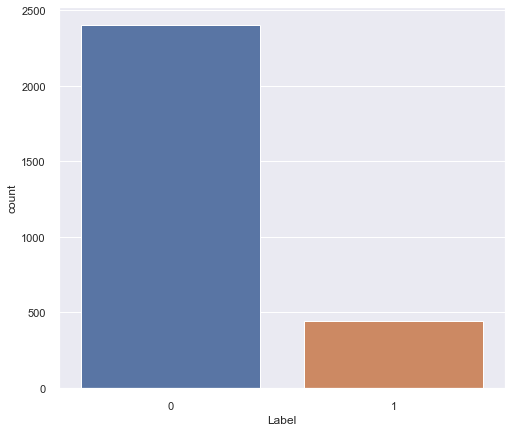

Percentage of the Spam emails in our dataset: 15.641476274165203 %


In [10]:
# First lets check the data available for each lable.
jtplot.style(theme='monokai', context='notebook', ticks=True)
sns.set_theme(style="darkgrid")
sns.countplot(data['Label']);
plt.show()

print(f"Percentage of the Spam emails in our dataset: {((data[data.Label==1].shape[0]/data.shape[0])*100)} %")

As the data available to us are imbalance, we might need to sample our dataset for better resuts. <br>
Would try this one out at out data exploration stages

As we would be working will only text data, we need to convert our string data into numerical form.

In [11]:
# First step in this is to remove all stop words present in our test
stops = {"0o", "0s", "3a", "3b", "3d", "6b", "6o", "a", "a1", "a2", "a3", "a4", "ab", "able", "about", "above", "abst", "ac", "accordance", "according", "accordingly", "across", "act", "actually", "ad", "added", "adj", "ae", "af", "affected", "affecting", "affects", "after", "afterwards", "ag", "again", "against", "ah", "ain", "ain't", "aj", "al", "all", "allow", "allows", "almost", "alone", "along", "already", "also", "although", "always", "am", "among", "amongst", "amoungst", "amount", "an", "and", "announce", "another", "any", "anybody", "anyhow", "anymore", "anyone", "anything", "anyway", "anyways", "anywhere", "ao", "ap", "apart", "apparently", "appear", "appreciate", "appropriate", "approximately", "ar", "are", "aren", "arent", "aren't", "arise", "around", "as", "a's", "aside", "ask", "asking", "associated", "at", "au", "auth", "av", "available", "aw", "away", "awfully", "ax", "ay", "az", "b", "b1", "b2", "b3", "ba", "back", "bc", "bd", "be", "became", "because", "become", "becomes", "becoming", "been", "before", "beforehand", "begin", "beginning", "beginnings", "begins", "behind", "being", "believe", "below", "beside", "besides", "best", "better", "between", "beyond", "bi", "bill", "biol", "bj", "bk", "bl", "bn", "both", "bottom", "bp", "br", "brief", "briefly", "bs", "bt", "bu", "but", "bx", "by", "c", "c1", "c2", "c3", "ca", "call", "came", "can", "cannot", "cant", "can't", "cause", "causes", "cc", "cd", "ce", "certain", "certainly", "cf", "cg", "ch", "changes", "ci", "cit", "cj", "cl", "clearly", "cm", "c'mon", "cn", "co", "com", "come", "comes", "con", "concerning", "consequently", "consider", "considering", "contain", "containing", "contains", "corresponding", "could", "couldn", "couldnt", "couldn't", "course", "cp", "cq", "cr", "cry", "cs", "c's", "ct", "cu", "currently", "cv", "cx", "cy", "cz", "d", "d2", "da", "date", "dc", "dd", "de", "definitely", "describe", "described", "despite", "detail", "df", "di", "did", "didn", "didn't", "different", "dj", "dk", "dl", "do", "does", "doesn", "doesn't", "doing", "don", "done", "don't", "down", "downwards", "dp", "dr", "ds", "dt", "du", "due", "during", "dx", "dy", "e", "e2", "e3", "ea", "each", "ec", "ed", "edu", "ee", "ef", "effect", "eg", "ei", "eight", "eighty", "either", "ej", "el", "eleven", "else", "elsewhere", "em", "empty", "en", "end", "ending", "enough", "entirely", "eo", "ep", "eq", "er", "es", "especially", "est", "et", "et-al", "etc", "eu", "ev", "even", "ever", "every", "everybody", "everyone", "everything", "everywhere", "ex", "exactly", "example", "except", "ey", "f", "f2", "fa", "far", "fc", "few", "ff", "fi", "fifteen", "fifth", "fify", "fill", "find", "fire", "first", "five", "fix", "fj", "fl", "fn", "fo", "followed", "following", "follows", "for", "former", "formerly", "forth", "forty", "found", "four", "fr", "from", "front", "fs", "ft", "fu", "full", "further", "furthermore", "fy", "g", "ga", "gave", "ge", "get", "gets", "getting", "gi", "give", "given", "gives", "giving", "gj", "gl", "go", "goes", "going", "gone", "got", "gotten", "gr", "greetings", "gs", "gy", "h", "h2", "h3", "had", "hadn", "hadn't", "happens", "hardly", "has", "hasn", "hasnt", "hasn't", "have", "haven", "haven't", "having", "he", "hed", "he'd", "he'll", "hello", "help", "hence", "her", "here", "hereafter", "hereby", "herein", "heres", "here's", "hereupon", "hers", "herself", "hes", "he's", "hh", "hi", "hid", "him", "himself", "his", "hither", "hj", "ho", "home", "hopefully", "how", "howbeit", "however", "how's", "hr", "hs", "http", "hu", "hundred", "hy", "i", "i2", "i3", "i4", "i6", "i7", "i8", "ia", "ib", "ibid", "ic", "id", "i'd", "ie", "if", "ig", "ignored", "ih", "ii", "ij", "il", "i'll", "im", "i'm", "immediate", "immediately", "importance", "important", "in", "inasmuch", "inc", "indeed", "index", "indicate", "indicated", "indicates", "information", "inner", "insofar", "instead", "interest", "into", "invention", "inward", "io", "ip", "iq", "ir", "is", "isn", "isn't", "it", "itd", "it'd", "it'll", "its", "it's", "itself", "iv", "i've", "ix", "iy", "iz", "j", "jj", "jr", "js", "jt", "ju", "just", "k", "ke", "keep", "keeps", "kept", "kg", "kj", "km", "know", "known", "knows", "ko", "l", "l2", "la", "largely", "last", "lately", "later", "latter", "latterly", "lb", "lc", "le", "least", "les", "less", "lest", "let", "lets", "let's", "lf", "like", "liked", "likely", "line", "little", "lj", "ll", "ll", "ln", "lo", "look", "looking", "looks", "los", "lr", "ls", "lt", "ltd", "m", "m2", "ma", "made", "mainly", "make", "makes", "many", "may", "maybe", "me", "mean", "means", "meantime", "meanwhile", "merely", "mg", "might", "mightn", "mightn't", "mill", "million", "mine", "miss", "ml", "mn", "mo", "more", "moreover", "most", "mostly", "move", "mr", "mrs", "ms", "mt", "mu", "much", "mug", "must", "mustn", "mustn't", "my", "myself", "n", "n2", "na", "name", "namely", "nay", "nc", "nd", "ne", "near", "nearly", "necessarily", "necessary", "need", "needn", "needn't", "needs", "neither", "never", "nevertheless", "new", "next", "ng", "ni", "nine", "ninety", "nj", "nl", "nn", "no", "nobody", "non", "none", "nonetheless", "noone", "nor", "normally", "nos", "not", "noted", "nothing", "novel", "now", "nowhere", "nr", "ns", "nt", "ny", "o", "oa", "ob", "obtain", "obtained", "obviously", "oc", "od", "of", "off", "often", "og", "oh", "oi", "oj", "ok", "okay", "ol", "old", "om", "omitted", "on", "once", "one", "ones", "only", "onto", "oo", "op", "oq", "or", "ord", "os", "ot", "other", "others", "otherwise", "ou", "ought", "our", "ours", "ourselves", "out", "outside", "over", "overall", "ow", "owing", "own", "ox", "oz", "p", "p1", "p2", "p3", "page", "pagecount", "pages", "par", "part", "particular", "particularly", "pas", "past", "pc", "pd", "pe", "per", "perhaps", "pf", "ph", "pi", "pj", "pk", "pl", "placed", "please", "plus", "pm", "pn", "po", "poorly", "possible", "possibly", "potentially", "pp", "pq", "pr", "predominantly", "present", "presumably", "previously", "primarily", "probably", "promptly", "proud", "provides", "ps", "pt", "pu", "put", "py", "q", "qj", "qu", "que", "quickly", "quite", "qv", "r", "r2", "ra", "ran", "rather", "rc", "rd", "re", "readily", "really", "reasonably", "recent", "recently", "ref", "refs", "regarding", "regardless", "regards", "related", "relatively", "research", "research-articl", "respectively", "resulted", "resulting", "results", "rf", "rh", "ri", "right", "rj", "rl", "rm", "rn", "ro", "rq", "rr", "rs", "rt", "ru", "run", "rv", "ry", "s", "s2", "sa", "said", "same", "saw", "say", "saying", "says", "sc", "sd", "se", "sec", "second", "secondly", "section", "see", "seeing", "seem", "seemed", "seeming", "seems", "seen", "self", "selves", "sensible", "sent", "serious", "seriously", "seven", "several", "sf", "shall", "shan", "shan't", "she", "shed", "she'd", "she'll", "shes", "she's", "should", "shouldn", "shouldn't", "should've", "show", "showed", "shown", "showns", "shows", "si", "side", "significant", "significantly", "similar", "similarly", "since", "sincere", "six", "sixty", "sj", "sl", "slightly", "sm", "sn", "so", "some", "somebody", "somehow", "someone", "somethan", "something", "sometime", "sometimes", "somewhat", "somewhere", "soon", "sorry", "sp", "specifically", "specified", "specify", "specifying", "sq", "sr", "ss", "st", "still", "stop", "strongly", "sub", "substantially", "successfully", "such", "sufficiently", "suggest", "sup", "sure", "sy", "system", "sz", "t", "t1", "t2", "t3", "take", "taken", "taking", "tb", "tc", "td", "te", "tell", "ten", "tends", "tf", "th", "than", "thank", "thanks", "thanx", "that", "that'll", "thats", "that's", "that've", "the", "their", "theirs", "them", "themselves", "then", "thence", "there", "thereafter", "thereby", "thered", "therefore", "therein", "there'll", "thereof", "therere", "theres", "there's", "thereto", "thereupon", "there've", "these", "they", "theyd", "they'd", "they'll", "theyre", "they're", "they've", "thickv", "thin", "think", "third", "this", "thorough", "thoroughly", "those", "thou", "though", "thoughh", "thousand", "three", "throug", "through", "throughout", "thru", "thus", "ti", "til", "tip", "tj", "tl", "tm", "tn", "to", "together", "too", "took", "top", "toward", "towards", "tp", "tq", "tr", "tried", "tries", "truly", "try", "trying", "ts", "t's", "tt", "tv", "twelve", "twenty", "twice", "two", "tx", "u", "u201d", "ue", "ui", "uj", "uk", "um", "un", "under", "unfortunately", "unless", "unlike", "unlikely", "until", "unto", "uo", "up", "upon", "ups", "ur", "us", "use", "used", "useful", "usefully", "usefulness", "uses", "using", "usually", "ut", "v", "va", "value", "various", "vd", "ve", "ve", "very", "via", "viz", "vj", "vo", "vol", "vols", "volumtype", "vq", "vs", "vt", "vu", "w", "wa", "want", "wants", "was", "wasn", "wasnt", "wasn't", "way", "we", "wed", "we'd", "welcome", "well", "we'll", "well-b", "went", "were", "we're", "weren", "werent", "weren't", "we've", "what", "whatever", "what'll", "whats", "what's", "when", "whence", "whenever", "when's", "where", "whereafter", "whereas", "whereby", "wherein", "wheres", "where's", "whereupon", "wherever", "whether", "which", "while", "whim", "whither", "who", "whod", "whoever", "whole", "who'll", "whom", "whomever", "whos", "who's", "whose", "why", "why's", "wi", "widely", "will", "willing", "wish", "with", "within", "without", "wo", "won", "wonder", "wont", "won't", "words", "world", "would", "wouldn", "wouldnt", "wouldn't", "www", "x", "x1", "x2", "x3", "xf", "xi", "xj", "xk", "xl", "xn", "xo", "xs", "xt", "xv", "xx", "y", "y2", "yes", "yet", "yj", "yl", "you", "youd", "you'd", "you'll", "your", "youre", "you're", "yours", "yourself", "yourselves", "you've", "yr", "ys", "yt", "z", "zero", "zi", "zz"}

a = []
b = []
for sen in data['Email_Subject']:
    a.append(' '.join([word for word in re.split("\W+",sen.lower()) if word.lower() not in stops]))
data['Email_Subject'] = pd.DataFrame(a,columns=["Email_Subject"]).values
for w in data['Email_Content']:
    b.append(' '.join([word for word in re.split("\W+",w.lower()) if word.lower() not in stops]))
data['Email_Content'] = pd.DataFrame(b,columns=["Email_Content"]).values

In [12]:
data.head()

,Email_Content,Email_Subject,Label
0,url pheasants reared britain fastest growing i...,born wild shot,0
1,url tue sep gmt overworked web development tim...,overworked web development time stu,0
2,thought pass favorite radio station raleigh in...,internet radio college station,0
3,lol doomed thousands men wear work day chastit...,ouch,0
4,time hesty wrote rpmbuild rebuild options alsa...,alsa problem null kernel,0


Now we would perform Stemming of our text, to get a much more structured data.

In [13]:
# Snowball Stemming
def stemming_word(data,splitting = True,type_of = "snow"):
    if type_of.lower() == "snow":
        stemmer = SnowballStemmer('english')
        a = []
        if splitting == True:
            a = data.apply(lambda x: [stemmer.stem(y) for y in x.split()])
            a = a.str.join(" ")
        else:
            a = data.apply(lambda k: [stemmer.stem(y) for y in k])
            a = a.str.join("")
        return a
    if type_of.lower() == "porter":
        stemmer = PorterStemmer()
        a = []
        if splitting == True:
            a = data.apply(lambda x: [stemmer.stem(y) for y in x.split()])
            a = a.str.join(" ")
        else:
            a = data.apply(lambda k: [stemmer.stem(y) for y in k])
            a = a.str.join("")
        return a
    if type_of.lower()=="lemm":
        lem = WordNetLemmatizer()
        a = []
        if splitting == True:
            a = data.apply(lambda x: [lem.lemmatize(y) for y in x.split()])
            a = a.str.join(" ")
        else:
            a = data.apply(lambda k: [lem.lemmatize(y) for y in k])
            a = a.str.join("")
        return a
    else:
        print("Plese Select the mentioned Options for 'type_of' field:\n")
        print("1>'Snow': SnowballStemmer\n2>'Porter':PorterStemmer\n3>'Lemm':WordNetLemmatizer")

As the text's has been processed, we are going to convert text into numeric form.<br>
For this we would use BagOfWords and TFI-IDF techniques.<br>
Word2Vec cannot be used as there is not enough data to create a corpus big enough to learn anything meaningful.

In [22]:
# Creating a function that returns the vectorized value when it is called
def text_to_numbers(data,model='BOW',gram=1,feat_names=False):
    if model.lower()=='bow':
        vectorizer = CountVectorizer(ngram_range=(1, gram))
        x = vectorizer.fit_transform(data)
        if feat_names==True:
            count_list = x.toarray().sum(axis=0)
            word_freq = dict(zip(vectorizer.get_feature_names(),count_list))
            return word_freq
        else:
            return x
    if model.lower()=='tfidf':
        vectorizer = TfidfVectorizer()
        x = vectorizer.fit_transform(data)
        if feat_names== True:
            count_list = x.toarray().sum(axis=0)
            word_freq = dict(zip(vectorizer.get_feature_names(),count_list))
            return word_freq
        else:
            return x
    else:
        print("Please enter: \n'model':\n 'BOW': Bag of Words\n 'TFIDF':TF-IDF\n'gram' for N_Gram: mention a nunber(Between 1-4) if 'BOW'is closen\n")
        print("If you want the feature names, please make 'feat_names' as true\nThis would only return the geature names")

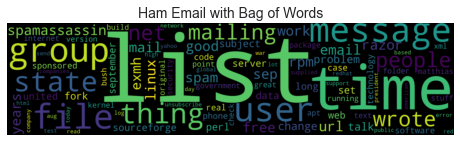

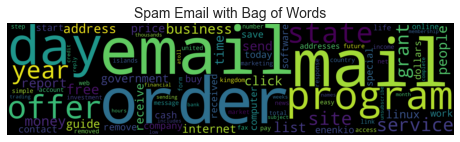

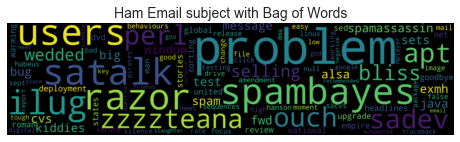

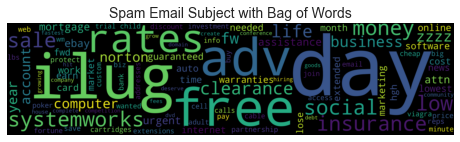

In [69]:
# Create WordClould to check the difference between Spam and Ham Emails.
import operator
from wordcloud import WordCloud, STOPWORDS
def word_cloud(data,model = "BOW",gram=1,n_words=100,title="Email"):
    word_freq = text_to_numbers(data,model,gram,feat_names=True)
    features_freq = dict(sorted(word_freq.items(),key=operator.itemgetter(1),reverse=True))
    #{A:N for (A,N) in [x for x in features_freq.items()][:4]}
    cloud = list({A:N for (A,N) in [x for x in features_freq.items()][:n_words]}.keys())
    wordcloud = WordCloud(width = 4000, height = 1000, 
                background_color ='black', min_font_size = 10).generate(" ".join(cloud))
    plt.figure(figsize = (8, 8), facecolor = None)
    plt.title(title, fontsize=14)
    plt.imshow(wordcloud,interpolation="bilinear") 
    plt.axis("off")
    plt.show() 
word_cloud(data[data.Label==0]['Email_Content'],title="Ham Email with Bag of Words")
word_cloud(data[data.Label==1]['Email_Content'],title="Spam Email with Bag of Words")
word_cloud(data[data.Label==0]['Email_Subject'],title="Ham Email subject with Bag of Words")
word_cloud(data[data.Label==1]['Email_Subject'],title="Spam Email Subject with Bag of Words")

It could be seen that the words in spam and ham are mostly different.<br>Now from here we would proceed with modeling our data.

# Modeling

As our baselining model. lets try Naive Bayes Classifier

In [64]:
# This function will provide result to oour classification model
def validate_result(y_true, y_pred,model="Model"):
    print(f"The Result for the {model} Classification is a Below\n")
    conf = confusion_matrix(y_true, y_pred)
    b = sns.heatmap(conf, cmap="YlGnBu",annot=True)
    b.axes.set_title("Confusion Matrix",fontsize=20)
    b.set_xlabel("Predicted Value",fontsize=16)
    b.set_ylabel("True Value",fontsize=16)
    b.tick_params(labelsize=16)
    print("=="*50)
    print(f"Recall Score: {recall_score(y_true, y_pred)*100} %")
    print(f"Precision Score: {precision_score(y_true, y_pred)*100} %")
    print("F1 Score: ",f1_score(y_true, y_pred))
    print("Log Loss: ",log_loss(y_true, y_pred))
    report = classification_report(y_true, y_pred, output_dict=True)
    df = pd.DataFrame(report).transpose()
    print("Classification Report:\n",df)

In [21]:
# Merge Email Subject and EMail column together
def merge_sparse(mat1,mat2):
    return hstack([mat1,mat2])

In [27]:
# Prepairing our data to go through modelling
# 1. Stemming
# 2. Text to Number
# Snowball Stemming
subject = stemming_word(data['Email_Subject'],splitting = False,type_of = "Snow")
content = stemming_word(data['Email_Content'],splitting = True,type_of = "Snow")
# Bag Of Words
subject = text_to_numbers(subject,model='BOW',gram=1,feat_names=False)
content = text_to_numbers(content,model='BOW',gram=1,feat_names=False)
# Creating out independent Variable
X = merge_sparse(subject,content)
y = data['Label']

In [28]:
# Seperating Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.20, random_state=42)

The Result for the Multinomial Naive Bayes Classification is a Below

Recall Score:  0.9032258064516129
Precision Score:  0.8
F1 Score:  0.8484848484848486
Log Loss:  1.731295043263751
Classification Report:
               precision    recall  f1-score     support
0              0.981763  0.958457  0.969970  337.000000
1              0.800000  0.903226  0.848485   62.000000
accuracy       0.949875  0.949875  0.949875    0.949875
macro avg      0.890881  0.930841  0.909227  399.000000
weighted avg   0.953519  0.949875  0.951093  399.000000


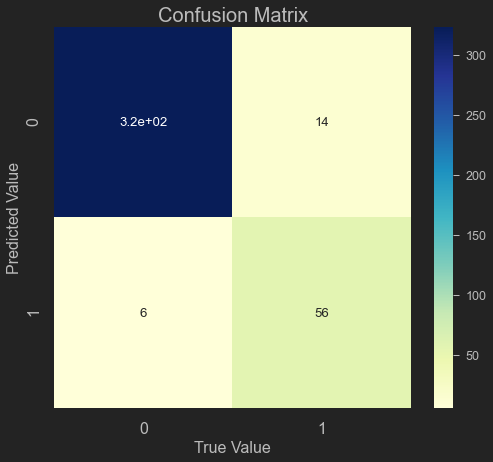

In [40]:
# MultinomialNB
clf = MultinomialNB()
clf.fit(X_train, y_train)
validate_result(y_cv,clf.predict(X_cv),model="Multinomial Naive Bayes")

In [81]:
# Lets perform a hyperparameter tuning on multiple models
def hyperparameter_tuning(X_train,y_train):
    # Parameters
    log_support_param = {"penalty":["l1","l2","elasticnet"],"C":[0.0001,0.001,.01,0.1,1,10,100,1000],"solver":['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}
    dt_params = {"criterion": ["gini", "entropy"], "max_depth": list(range(2,7,1)), "min_samples_leaf": list(range(5,7,1))}
    knn_params = {"n_neighbors": [2,3,5,7,9]}
    scm_param = {"C":[0.0001,0.001,.01,0.1,1,10,100,1000],'kernel':['linear','poly','rbf','sigmoid']}

    # Logistic Regression
    logistic = LogisticRegression(random_state=0)
    rand_log = RandomizedSearchCV(logistic, log_support_param)
    rand_log.fit(X_train, y_train)

    log_best = rand_log.best_estimator_
    print("\n")
    print("Logistic Regression Best Estimators: \n", log_best)
    print(f"Logistic Regression Best Score: {(rand_log.best_score_)*100} %")
    print("Logistic Regression Best Parameters: ", rand_log.best_params_)
    print("="*100)

    print("\n")

    # Support Vector Classifier
    support = SVC()
    rand_supp = RandomizedSearchCV(support, scm_param)
    rand_supp.fit(X_train, y_train)

    svc_best = rand_supp.best_estimator_
    print("\n")
    print("Support Vector Classifier Best Estimators: ", svc_best)
    print(f"Support Vector Classifier Best Score: {(rand_supp.best_score_)*100} %")
    print("Support Vector Classifier Best Parameters: ", rand_supp.best_params_)
    print("="*100)

    print("\n")
    # DecisionTree Classifier
    rand_tree = RandomizedSearchCV(DecisionTreeClassifier(), dt_params)
    rand_tree.fit(X_train, y_train)

    tree_best = rand_tree.best_estimator_
    print("\n")
    print("DecisionTree Classifier Best Estimators: ", tree_best)
    print(f"DecisionTree Classifier Best Score:  {(rand_tree.best_score_)*100} %")
    print("DecisionTree Classifier Best Parameters: ", rand_tree.best_params_)
    
    
    # KNears best estimator
    rand_knn = RandomizedSearchCV(KNeighborsClassifier(), knn_params)
    rand_knn.fit(X_train, y_train)

    knn_best = rand_knn.best_estimator_
    print("\n")
    print("KNN Best Estimators: ", knn_best)
    print(f"KNN Best Score: {(rand_knn.best_score_)*100} %")
    print("KNN Best Parameters: ", rand_knn.best_params_)
    print("="*100)
    print("\n")

In [73]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
hyperparameter_tuning(X_train,y_train)



Logistic Regression Best Estimators: 
 LogisticRegression(C=1, random_state=0)
Logistic Regression Best Score: 97.92807712781688 %
Logistic Regression Best Parameters:  {'solver': 'lbfgs', 'penalty': 'l2', 'C': 1}




Support Vector Classifier Best Estimators:  SVC(C=0.1, kernel='linear')
Support Vector Classifier Best Score: 97.36263086295617 %
Support Vector Classifier Best Parameters:  {'kernel': 'linear', 'C': 0.1}




DecisionTree Classifier Best Estimators:  DecisionTreeClassifier(max_depth=6, min_samples_leaf=5)
DecisionTree Classifier Best Score:  91.58415646379211 %
DecisionTree Classifier Best Parameters:  {'min_samples_leaf': 5, 'max_depth': 6, 'criterion': 'gini'}


KNN Best Estimators:  KNeighborsClassifier(n_neighbors=2)
KNN Best Score: 69.91088503775556 %
KNN Best Parameters:  {'n_neighbors': 2}




KNN performs the worst Support Vector and Logistic Regression performs the best<br>
Lets see how well these models are with the parameters from our search

The Result for the Model Classification is a Below

Recall Score:  0.5645161290322581
Precision Score:  0.8974358974358975
F1 Score:  0.6930693069306931
Log Loss:  2.6834718461953693
Classification Report:
               precision    recall  f1-score     support
0              0.925000  0.988131  0.955524  337.000000
1              0.897436  0.564516  0.693069   62.000000
accuracy       0.922306  0.922306  0.922306    0.922306
macro avg      0.911218  0.776323  0.824296  399.000000
weighted avg   0.920717  0.922306  0.914741  399.000000


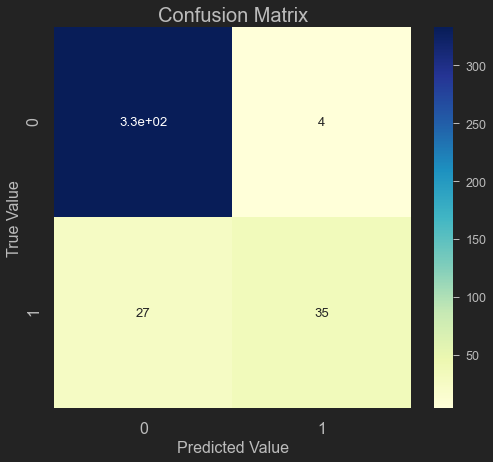

In [55]:
# Logistic Regression
logit_sgd = SGDClassifier(alpha=0.01, early_stopping=True, loss='log')
logit_sgd.fit(X_train,y_train)
validate_result(y_cv,logit_sgd.predict(X_cv))

In [59]:
from sklearn.linear_model import LogisticRegression
param = {"penalty":["l1","l2","elasticnet"],"C":[0.0001,0.001,.01,0.1,1,10],"solver":['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}
clf = RandomizedSearchCV(LogisticRegression(random_state=0), param)
clf.fit(X_train,y_train)

RandomizedSearchCV(estimator=LogisticRegression(random_state=0),
                   param_distributions={'C': [0.0001, 0.001, 0.01, 0.1, 1, 10],
                                        'penalty': ['l1', 'l2', 'elasticnet'],
                                        'solver': ['newton-cg', 'lbfgs',
                                                   'liblinear', 'sag',
                                                   'saga']})

In [66]:
print("Logistic Regression Best Estimators: ", clf.best_estimator_)
print(f"Logistic Regression Best Score: {(clf.best_score_)*100} %")
print("Logistic Regression Best Parameters: ", clf.best_params_)

Logistic Regression Best Estimators:  LogisticRegression(C=1, random_state=0, solver='liblinear')
Logistic Regression Best Score: 98.05366613434276 %
Logistic Regression Best Parameters:  {'solver': 'liblinear', 'penalty': 'l2', 'C': 1}


The Result for the Model Classification is a Below

Recall Score: 90.32258064516128 %
Precision Score: 98.24561403508771 %
F1 Score:  0.9411764705882352
Log Loss:  0.6059454495283342
Classification Report:
               precision    recall  f1-score     support
0              0.982456  0.997033  0.989691  337.000000
1              0.982456  0.903226  0.941176   62.000000
accuracy       0.982456  0.982456  0.982456    0.982456
macro avg      0.982456  0.950129  0.965434  399.000000
weighted avg   0.982456  0.982456  0.982152  399.000000


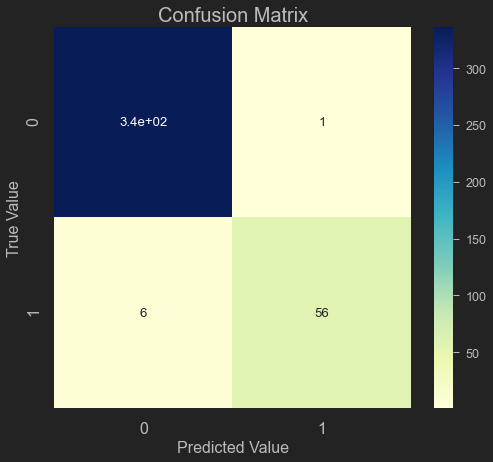

In [65]:
logit = LogisticRegression(C=1,solver='liblinear')
logit.fit(X_train,y_train)
validate_result(y_cv,logit.predict(X_cv))

We are getting a above 90 % Recall and Precision Score with Logistic Regression<br>
Now lets try with our SVM Classification

In [67]:
from sklearn.svm import SVC
params_svm = {"C":[0.0001,0.001,.01,0.1,1,10],'kernel':['linear','poly','rbf','sigmoid']}
clf = RandomizedSearchCV(SVC(), params_svm)
clf.fit(X_train,y_train)

print("SVC Best Estimators: ", clf.best_estimator_)
print(f"SVC Best Score: {(clf.best_score_)*100} %")
print("SVC Best Parameters: ", clf.best_params_)

SVC Best Estimators:  SVC(C=0.1, kernel='linear')
SVC Best Score: 97.36263086295617 %
SVC Best Parameters:  {'kernel': 'linear', 'C': 0.1}


The Result for the Model Classification is a Below

Recall Score: 88.70967741935483 %
Precision Score: 98.21428571428571 %
F1 Score:  0.9322033898305085
Log Loss:  0.6925087988890126
Classification Report:
               precision    recall  f1-score    support
0              0.979592  0.997033  0.988235  337.00000
1              0.982143  0.887097  0.932203   62.00000
accuracy       0.979950  0.979950  0.979950    0.97995
macro avg      0.980867  0.942065  0.960219  399.00000
weighted avg   0.979988  0.979950  0.979529  399.00000


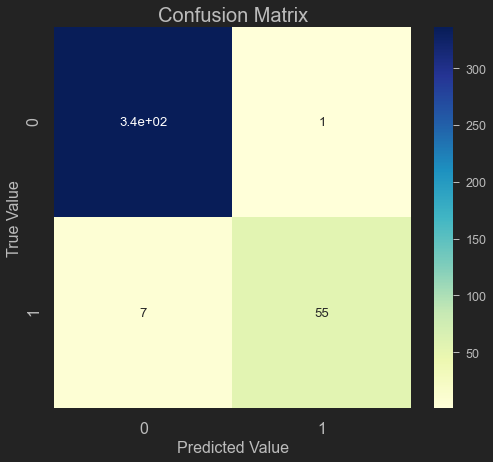

In [68]:
supp = SVC(C=0.1, kernel='linear')
supp.fit(X_train,y_train)
validate_result(y_cv,supp.predict(X_cv))

With Bag Of Words and Snowball Stemming, Logistic Regression provided a better result than our Support Vector Classifier

In [74]:
# Prepairing our data to go through modelling
# 1. Stemming
# 2. Text to Number
# Snowball Stemming
subject = stemming_word(data['Email_Subject'],splitting = False,type_of = "porter")
content = stemming_word(data['Email_Content'],splitting = True,type_of = "porter")
# Bag Of Words
subject = text_to_numbers(subject,model='BOW',gram=1,feat_names=False)
content = text_to_numbers(content,model='BOW',gram=1,feat_names=False)
# Creating out independent Variable
X = merge_sparse(subject,content)
y = data['Label']

In [75]:
# Seperating Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.20, random_state=42)

In [82]:
hyperparameter_tuning(X_train,y_train)



Logistic Regression Best Estimators: 
 LogisticRegression(C=1, random_state=0, solver='liblinear')
Logistic Regression Best Score: 97.99077305258177 %
Logistic Regression Best Parameters:  {'solver': 'liblinear', 'penalty': 'l2', 'C': 1}




Support Vector Classifier Best Estimators:  SVC(C=10, kernel='linear')
Support Vector Classifier Best Score: 95.91786439541806 %
Support Vector Classifier Best Parameters:  {'kernel': 'linear', 'C': 10}




DecisionTree Classifier Best Estimators:  DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_leaf=5)
DecisionTree Classifier Best Score:  91.26890242700263 %
DecisionTree Classifier Best Parameters:  {'min_samples_leaf': 5, 'max_depth': 5, 'criterion': 'entropy'}


KNN Best Estimators:  KNeighborsClassifier(n_neighbors=2)
KNN Best Score: 70.03667120127758 %
KNN Best Parameters:  {'n_neighbors': 2}




The Result for the Model Classification is a Below

Recall Score: 91.93548387096774 %
Precision Score: 98.27586206896551 %
F1 Score:  0.95
Log Loss:  0.5193821001676558
Classification Report:
               precision    recall  f1-score     support
0              0.985337  0.997033  0.991150  337.000000
1              0.982759  0.919355  0.950000   62.000000
accuracy       0.984962  0.984962  0.984962    0.984962
macro avg      0.984048  0.958194  0.970575  399.000000
weighted avg   0.984937  0.984962  0.984756  399.000000


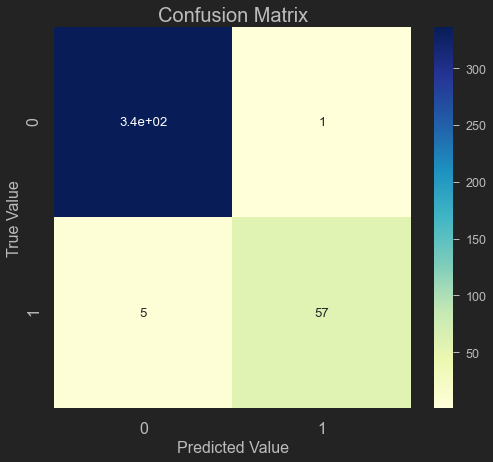

In [80]:
# Similarly Logistic Regression and SVM performs best
logist =  LogisticRegression(C=1, random_state=0, solver='liblinear')
logist.fit(X_train,y_train)
validate_result(y_cv,logist.predict(X_cv))

The Result for the Support Vector Classification is a Below

Recall Score: 87.09677419354838 %
Precision Score: 91.52542372881356 %
F1 Score:  0.8925619834710744
Log Loss:  1.1253335617067424
Classification Report:
               precision    recall  f1-score     support
0              0.976471  0.985163  0.980798  337.000000
1              0.915254  0.870968  0.892562   62.000000
accuracy       0.967419  0.967419  0.967419    0.967419
macro avg      0.945862  0.928065  0.936680  399.000000
weighted avg   0.966958  0.967419  0.967087  399.000000


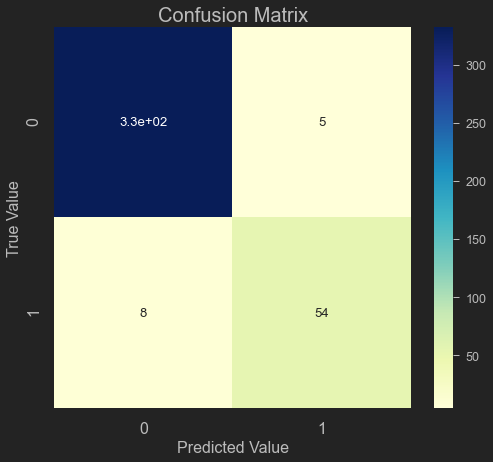

In [83]:
# Similarly Logistic Regression and SVM performs best
supp =  SVC(C=10, kernel='linear')
supp.fit(X_train,y_train)
validate_result(y_cv,supp.predict(X_cv),model="Support Vector")

Logistic Regression seems to be performing much better

In [84]:
# Prepairing our data to go through modelling
# 1. Stemming
# 2. Text to Number
# Snowball Stemming
subject = stemming_word(data['Email_Subject'],splitting = False,type_of = "lemm")
content = stemming_word(data['Email_Content'],splitting = True,type_of = "lemm")
# Bag Of Words
subject = text_to_numbers(subject,model='BOW',gram=1,feat_names=False)
content = text_to_numbers(content,model='BOW',gram=1,feat_names=False)
# Creating out independent Variable
X = merge_sparse(subject,content)
y = data['Label']
# Seperating Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.20, random_state=42)

In [85]:
hyperparameter_tuning(X_train,y_train)



Logistic Regression Best Estimators: 
 LogisticRegression(C=10, random_state=0, solver='liblinear')
Logistic Regression Best Score: 97.55111295124307 %
Logistic Regression Best Parameters:  {'solver': 'liblinear', 'penalty': 'l2', 'C': 10}




Support Vector Classifier Best Estimators:  SVC(C=1, kernel='linear')
Support Vector Classifier Best Score: 95.66629206837405 %
Support Vector Classifier Best Parameters:  {'kernel': 'linear', 'C': 1}




DecisionTree Classifier Best Estimators:  DecisionTreeClassifier(criterion='entropy', max_depth=6, min_samples_leaf=6)
DecisionTree Classifier Best Score:  91.0802231817196 %
DecisionTree Classifier Best Parameters:  {'min_samples_leaf': 6, 'max_depth': 6, 'criterion': 'entropy'}


KNN Best Estimators:  KNeighborsClassifier(n_neighbors=2)
KNN Best Score: 69.22004692336508 %
KNN Best Parameters:  {'n_neighbors': 2}




The Result for the LogisticRegression Classification is a Below

Recall Score: 91.93548387096774 %
Precision Score: 98.27586206896551 %
F1 Score:  0.95
Log Loss:  0.5193821001676558
Classification Report:
               precision    recall  f1-score     support
0              0.985337  0.997033  0.991150  337.000000
1              0.982759  0.919355  0.950000   62.000000
accuracy       0.984962  0.984962  0.984962    0.984962
macro avg      0.984048  0.958194  0.970575  399.000000
weighted avg   0.984937  0.984962  0.984756  399.000000


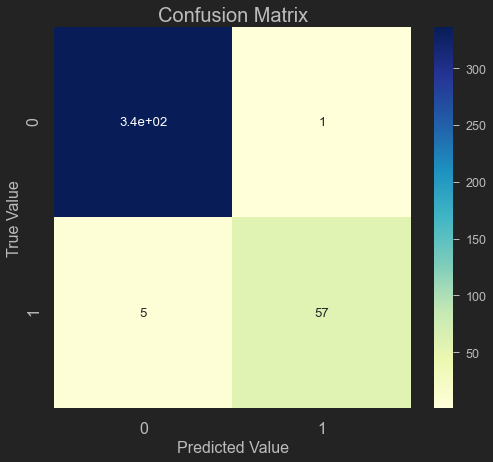

In [86]:
# Similarly Logistic Regression and SVM performs best
logist =  LogisticRegression(C=1, random_state=0, solver='liblinear')
logist.fit(X_train,y_train)
validate_result(y_cv,logist.predict(X_cv),model="LogisticRegression")

In [88]:
# Prepairing our data to go through modelling
# 1. Stemming
# 2. Text to Number
# Snowball Stemming
subject = stemming_word(data['Email_Subject'],splitting = False,type_of = "snow")
content = stemming_word(data['Email_Content'],splitting = True,type_of = "snow")
# Bag Of Words
subject = text_to_numbers(subject,model='Bow',gram=2,feat_names=False)
content = text_to_numbers(content,model='Bow',gram=2,feat_names=False)
# Creating out independent Variable
X = merge_sparse(subject,content)
y = data['Label']
# Seperating Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.20, random_state=42)

In [89]:
hyperparameter_tuning(X_train,y_train)



Logistic Regression Best Estimators: 
 LogisticRegression(C=100, random_state=0)
Logistic Regression Best Score: 96.86027483685258 %
Logistic Regression Best Parameters:  {'solver': 'lbfgs', 'penalty': 'l2', 'C': 100}




Support Vector Classifier Best Estimators:  SVC(C=100, kernel='linear')
Support Vector Classifier Best Score: 95.4155083693145 %
Support Vector Classifier Best Parameters:  {'kernel': 'linear', 'C': 100}




DecisionTree Classifier Best Estimators:  DecisionTreeClassifier(max_depth=6, min_samples_leaf=5)
DecisionTree Classifier Best Score:  91.89763608761655 %
DecisionTree Classifier Best Parameters:  {'min_samples_leaf': 5, 'max_depth': 6, 'criterion': 'gini'}


KNN Best Estimators:  KNeighborsClassifier(n_neighbors=2)
KNN Best Score: 62.183316574988666 %
KNN Best Parameters:  {'n_neighbors': 2}




The Result for the LogisticRegression Classification is a Below

Recall Score: 87.09677419354838 %
Precision Score: 93.10344827586206 %
F1 Score:  0.9
Log Loss:  1.0387682083424794
Classification Report:
               precision    recall  f1-score     support
0              0.976540  0.988131  0.982301  337.000000
1              0.931034  0.870968  0.900000   62.000000
accuracy       0.969925  0.969925  0.969925    0.969925
macro avg      0.953787  0.929549  0.941150  399.000000
weighted avg   0.969469  0.969925  0.969512  399.000000


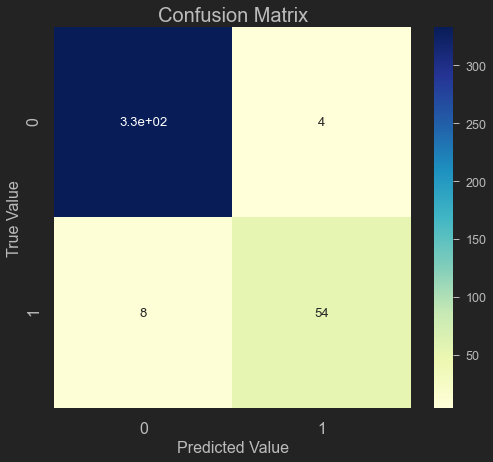

In [90]:
# Similarly Logistic Regression and SVM performs best
logist = LogisticRegression(C=100, random_state=0)
logist.fit(X_train,y_train)
validate_result(y_cv,logist.predict(X_cv),model="LogisticRegression")

Using 2 Gram did not give us a better result.